# Supervised Learning for Depression Detection in Online User Content

In this project, a labelled Reddit data collection from https://erisk.irlab.org/ is used.

The work is partially based on:

Proceedings of the Ninth International Conference of the CLEF Association (CLEF 2018)

@inproceedings{maupomemeurs2018,

author = {Diego Maupomé and Marie-Jean Meurs},

booktitle = {Experimental IR Meets Multilinguality, Multimodality, and Interaction. 

Proceedings of the Ninth International Conference of the {CLEF} Association ({CLEF} 2018)},

title = {{Using Topic Extraction on Social Media Content for the Early Detection of Depression}},

address   = {Avignon, France},

year = {2018}
}

Based on previous research, it has been hypothesized that the following features can help detecting depression from online user content:
* Time of day user writes messages
* Discussed topics: Emotions, relationships, themselves, mental disorders

In [66]:
from textblob import TextBlob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os 
from numpy.random import randint
import collections

from xml.dom import minidom
from datetime import datetime, date, time, timedelta
import random

import re
from nltk.tokenize import TweetTokenizer
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from joblib import dump


## ETL

In [ ]:
df = pd.DataFrame(columns=['subject', 'group'])
i=0
crs = open("golden_truth.txt", "r")
for column in ( raw.strip().split() for raw in crs ):  
    df.loc[i]=[column[0],column[1]]
    i+=1

names=df["subject"]
df_summary=pd.DataFrame(columns=['subject', 'group','message'])
j=0
for name in names:
    fileName = os.path.join("data/", name)
    fileName=fileName+".xml"
    xmldoc = minidom.parse(fileName)
    itemlist = xmldoc.getElementsByTagName('TEXT')

    row=df.loc[df['subject'] == name]
    for k in range(0,len(itemlist)):
        df_summary.loc[j]=[name,row["group"].values[0],(itemlist[k].firstChild.nodeValue)]
        j+=1

df_summary.to_csv('summary.csv')

In [70]:
df = pd.read_csv("summary.csv")
df.head()

,Unnamed: 0,subject,group,message
0,0,subject671,1,there's a pizza place a couple doors down and ...
1,1,subject671,1,i pour hot water into a pitcher while my ameri...
2,2,subject671,1,ombre pink drink has cool lime base too. i thi...
3,3,subject671,1,tall americano double sleeve no cup
4,4,subject671,1,"we print blank receipt paper, write our closin..."


In [71]:
df.shape

(127941, 4)

## EDA

In [8]:
df = pd.DataFrame(columns=['subject', 'group'])
i=0
crs = open("golden_truth.txt", "r")
for column in ( raw.strip().split() for raw in crs ):  
    df.loc[i]=[column[0],column[1]]
    i+=1

names=df["subject"]
t0 = 0
t1 = 0
total = 0
total0 = 0
total1 = 0
wordSum0 = 0
wordSum1 = 0
datesum0 = 0
datesum1 = 0
totalDateSum = 0

for name in names:
    fileName = os.path.join("data/", name)
    fileName=fileName+".xml"
    xmldoc = minidom.parse(fileName)
    itemlist = xmldoc.getElementsByTagName('TEXT')
    total+=len(itemlist)

    row=df.loc[df['subject'] == name]
    
    datelist = xmldoc.getElementsByTagName('DATE')
    firstDate=datelist[0].firstChild.nodeValue
    lastDate=datelist[len(datelist)-1].firstChild.nodeValue
    fD=datetime.strptime(firstDate, '%Y-%m-%d %H:%M:%S') #2018-01-14 13:47:07
    lD=datetime.strptime(lastDate, '%Y-%m-%d %H:%M:%S')
    diff=lD-fD
    totalDateSum += diff.days
    summ=0
    for i in range(0,len(itemlist)):
        s=(itemlist[i].firstChild.nodeValue)
        summ+=len(s.split())
        
    if(row["group"].values[0]=="0"):
        total0+=len(itemlist)
        t0+=1
        wordSum0+=summ
        datesum0+=diff.days
    elif(row["group"].values[0]=="1"):
        total1+=len(itemlist)
        t1+=1
        wordSum1+=summ
        datesum1+=diff.days
    else:
        print("Something went wrong")
        break

print("Number of messages: {}".format(total))
print("Number of messages from not depressed: {}".format(total0))
print("Number of messages from depressed: {}".format(total1))
print("Number of not depressed users: {}".format(t0))
print("Number of depressed users: {}".format(t1))

print("Avg message count: {}".format(round(total/(t0+t1)),0))
print("Avg message count not depressed: {}".format(round(total0/t0),0))
print("Avg message count depressed: {}".format(round(total1/t1),0))

print("Avg word count: {}".format(round((wordSum0+wordSum1)/total),0))
print("Avg word count not depressed: {}".format(round(wordSum0/total0),0))
print("Avg word count depressed: {}".format(round(wordSum1/total1),0))

print("Avg message history: {} days".format(round(totalDateSum/(t0+t1),0)))
print("Avg message history not depressed: {} days".format(round(datesum0/t0,0)))
print("Avg message history depressed: {} days".format(round(datesum1/t1,0)))

Number of messages: 127941
Number of messages from not depressed: 120988
Number of messages from depressed: 6953
Number of not depressed users: 299
Number of depressed users: 41
Avg message count: 376
Avg message count not depressed: 405
Avg message count depressed: 170
Avg word count: 30
Avg word count not depressed: 30
Avg word count depressed: 35
Avg message history: 751.0 days
Avg message history not depressed: 785.0 days
Avg message history depressed: 504.0 days


### Data preprocessing

In [72]:
stopword_list = stopwords.words('english')

def remove_whitespaces(text):
    """This function removes whitespaces)"""
    return ' '.join(text.split())


def lowercase_text(text):
    """This function makes text lowercase"""
    return str(text).lower()


def remove_emails(text):
    """This function removes emails from text"""
    return re.sub(r"\S*@\S*\s?", ' ', str(text))


def remove_domains(text):
    """This function removes .com .org .net .fi domains
    and strings with https www from text"""
    text = re.sub(r"[^\s]*\.(com|org|net|fi)\S*", ' ', str(text))
    text = re.sub('https?://\S+|www\.\S+', '', text)
    return text


def remove_brackets(text):
    """This function removes content within []-brackets and <>-marks from text"""
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    return text


def remove_punctuation(text):
    """This function removes punctuation from text"""
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)


def remove_numbers(text):
    """This function removes numbers, number series,
    and words that have numbers in them from text"""
    return re.sub('\w*\d\w*', '', text)


def remove_stopwords(text):
    tknzr = TweetTokenizer()
    text_tokens = tknzr.tokenize(text)
    filtered_tokens = [word for word in text_tokens if word not in stopword_list]
    filtered_text = " ".join(filtered_tokens)
    return filtered_text


def remove_single_chars(text):
    text = ' '.join([word for word in text.split() if len(word) > 1])
    return text


def limit_length(text):
    text = text.split()[:50]
    text = ' '.join(word for word in text)
    return text


def clean_text(text):
    """This function makes text lowercase, and removes domains, emails, punctuation, linebreaks,
    text within [] and <>, and words containing numbers. Filters out stopwords and custom words."""
    text = limit_length(text)
    text = remove_whitespaces(text)
    text = lowercase_text(text)
    text = remove_emails(text)
    text = remove_domains(text)
    text = remove_brackets(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = remove_single_chars(text)
    return text


In [73]:
for i, val in df.iterrows():
    df.at[i, "message"] = clean_text(val.message)

In [74]:
df.head()

,Unnamed: 0,subject,group,message
0,0,subject671,1,pizza place couple doors couple kids working c...
1,1,subject671,1,pour hot water pitcher americano shots pouring...
2,2,subject671,1,ombre pink drink cool lime base think lot cust...
3,3,subject671,1,tall americano double sleeve cup
4,4,subject671,1,print blank receipt paper write closing list c...


#### Message length

In [33]:
df['polarity'] = df['message'].map(lambda text: TextBlob(text).sentiment.polarity)
df['len'] = df['message'].apply(lambda x: len(str(x).split()))
df.head()

,subject,group,message,polarity,len
0,subject671,1,pizza place couple doors couple kids working c...,0.000000,18
1,subject671,1,pour hot water pitcher americano shots pouring...,0.233333,18
2,subject671,1,ombre pink drink cool lime base think lot cust...,-0.170000,15
3,subject671,1,tall americano double sleeve cup,0.000000,5
4,subject671,1,print blank receipt paper write closing list c...,0.166667,24


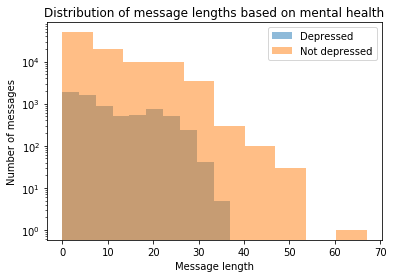

In [47]:
len_depressed = df.loc[df['group'] == "1", 'len']
len_happy = df.loc[df['group'] == "0", 'len']
plt.hist(len_depressed, alpha=0.5, label='Depressed', log=True)
plt.hist(len_happy, alpha=0.5, label='Not depressed', log=True)
plt.legend(loc='upper right')
plt.title("Distribution of message lengths based on mental health")
plt.xlabel("Message length")
plt.ylabel("Number of messages")
plt.show()

#### Polarity

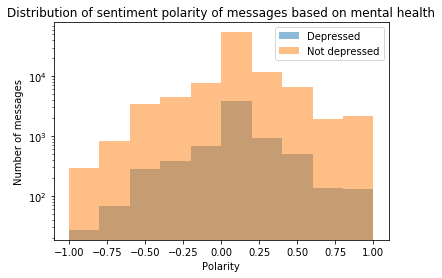

In [48]:
polarity_depressed = df.loc[df['group'] == "1", 'polarity']
polarity_happy = df.loc[df['group'] == "0", 'polarity']

plt.hist(polarity_depressed, alpha=0.5, label='Depressed', log=True)
plt.hist(polarity_happy, alpha=0.5, label='Not depressed', log=True)
plt.legend(loc='upper right')
plt.title("Distribution of sentiment polarity of messages based on mental health")
plt.xlabel("Polarity")
plt.ylabel("Number of messages")
plt.show()

#### Most common words and ngrams

In [ ]:
df_happy = df.loc[df['group'] == "0"]
df_depressed = df.loc[df['group'] == "1"]

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_words_happy = get_top_n_words(df_happy['message'], 50)
top_words_depressed = get_top_n_words(df_depressed['message'], 50)
features_rank_happy = np.array(sorted(top_words_happy, key=lambda x:x[1], reverse=True))
features_rank_depressed = np.array(sorted(top_words_depressed, key=lambda x:x[1], reverse=True))

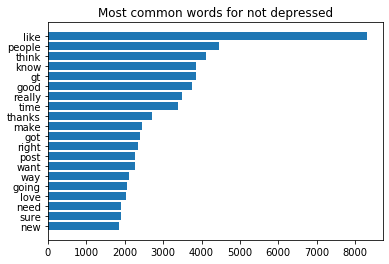

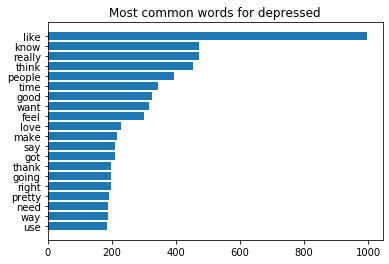

In [52]:
n = 20
plt.barh(-np.arange(n), features_rank_happy[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=features_rank_happy[:n, 0])
plt.title("Most common words for not depressed")
plt.show()

plt.barh(-np.arange(n), features_rank_depressed[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=features_rank_depressed[:n, 0])
plt.title("Most common words for depressed")
plt.show()

In [53]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams_happy = get_top_n_bigram(df_happy['message'], 50)
top_bigrams_depressed = get_top_n_bigram(df_depressed['message'], 50)
bi_features_rank_happy = np.array(sorted(top_bigrams_happy, key=lambda x:x[1], reverse=True))
bi_features_rank_depressed = np.array(sorted(top_bigrams_depressed, key=lambda x:x[1], reverse=True))

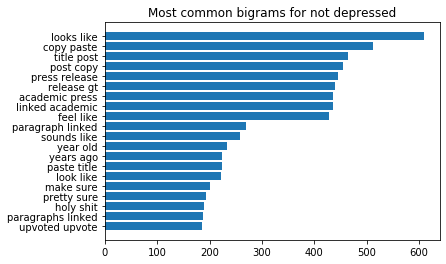

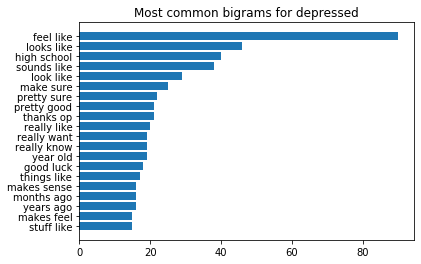

In [78]:
n = 20
plt.barh(-np.arange(n), bi_features_rank_happy[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=bi_features_rank_happy[:n, 0])
plt.title("Most common bigrams for not depressed")
plt.show()

plt.barh(-np.arange(n), bi_features_rank_depressed[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=bi_features_rank_depressed[:n, 0])
plt.title("Most common bigrams for depressed")
plt.show()

In [55]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_trigrams_happy = get_top_n_trigram(df_happy['message'], 50)
top_trirams_depressed = get_top_n_trigram(df_depressed['message'], 50)
tri_features_rank_happy = np.array(sorted(top_trigrams_happy, key=lambda x:x[1], reverse=True))
tri_features_rank_depressed = np.array(sorted(top_trirams_depressed, key=lambda x:x[1], reverse=True))

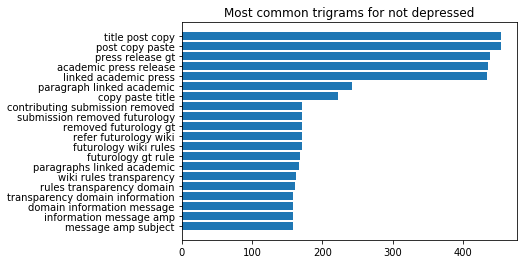

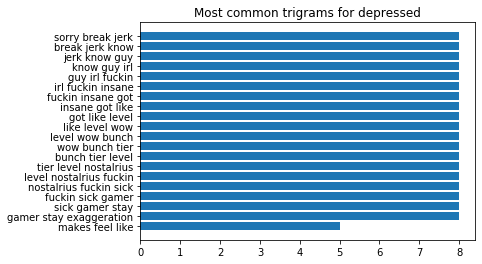

In [79]:
n = 20
plt.barh(-np.arange(n), tri_features_rank_happy[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=tri_features_rank_happy[:n, 0])
plt.title("Most common trigrams for not depressed")
plt.show()

plt.barh(-np.arange(n), tri_features_rank_depressed[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=tri_features_rank_depressed[:n, 0])
plt.title("Most common trigrams for depressed")
plt.show()

There is still some need for improvement in data cleansing.

In [97]:
df_happy = df.loc[df['group'] == 0]
df_depressed = df.loc[df['group'] == 1]
top_words_happy = get_top_n_words(df_happy['message'], 9000)
top_words_depressed = get_top_n_words(df_depressed['message'], 9000)

In [108]:
word_list=["happy", "sad", "love", "feel", "live", "kill", "death", "loneliness", "lonely", "anxiety", "depression", "suicide", 
           "advice", "therapy", "friend", "me", "family", "parents", "car", "football", "movie", "success", "help", "school", "kind", "sorry",
           "joy", "perfect", "animal", "movie", "game"
          ]
i=0
print("How commonly depressed and not depressed people use some specific words:")
for word, freq in top_words_happy:
    i+=1
    if(word in word_list):
        print("Not depressed: {} is {}. (count: {})".format(word, i, freq))
        
        j=0
        for word2, freq2 in top_words_depressed:
            j+=1
            if(word2 == word):
                print("Depressed: {} is {}. (count: {})".format(word, j, freq2))
                break
        print("_"*30)

How commonly depressed and not depressed people use some specific words:
Not depressed: love is 18. (count: 2491)
Depressed: love is 10. (count: 228)
______________________________
Not depressed: game is 27. (count: 2225)
Depressed: game is 40. (count: 125)
______________________________
Not depressed: feel is 42. (count: 1680)
Depressed: feel is 9. (count: 300)
______________________________
Not depressed: help is 76. (count: 1144)
Depressed: help is 48. (count: 115)
______________________________
Not depressed: sorry is 80. (count: 1089)
Depressed: sorry is 65. (count: 100)
______________________________
Not depressed: kind is 89. (count: 1028)
Depressed: kind is 33. (count: 128)
______________________________
Not depressed: live is 108. (count: 923)
Depressed: live is 96. (count: 75)
______________________________
Not depressed: friend is 126. (count: 817)
Depressed: friend is 81. (count: 84)
______________________________
Not depressed: school is 144. (count: 748)
Depressed: school

It can be be seen that depressed users discuss more commonly about emotions, relationships, and topics such as mental disorders.

### Selecting k best features

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=20).fit_transform(X, y)

## Categorization

### Message categorization

In [199]:
x_training_data, x_validation_data, y_training_data, y_validation_data = train_test_split(df["message"].values.astype('U'), df["group"], test_size=0.3, random_state=0)  
model = Pipeline([('vect', TfidfVectorizer()),
                            ('clf-lin-svm', LinearSVC(random_state=0))])
model = model.fit(x_training_data, y_training_data)

In [200]:
pred = model.predict(x_validation_data)

In [201]:
print(confusion_matrix(y_validation_data,pred))
print(accuracy_score(y_validation_data, pred, normalize=True))
print(precision_recall_fscore_support(y_validation_data, pred, average='weighted'))
print(precision_recall_fscore_support(y_validation_data, pred, average='micro'))
print(precision_recall_fscore_support(y_validation_data, pred, average='macro'))

[[36223   113]
 [ 1843   204]]
0.9490399395565745
(0.9351554549090215, 0.9490399395565745, 0.9309858494080593, None)
(0.9490399395565745, 0.9490399395565745, 0.9490399395565745, None)
(0.7975586069090361, 0.5482740863271034, 0.5731496083083842, None)


### User categorization

In [158]:
df_combined_messages = df.groupby(['subject', 'group'])['message'].agg(lambda x: ' '.join(x)).reset_index()

In [161]:
df_combined_messages.head()

,subject,group,message
0,subject0,0,little late agree thought saying bad overall s...
1,subject1027,0,goodbye jub jub want rub rub ...
2,subject1055,0,hi everyone leah remini author troublemaker su...
3,subject1064,1,thinking going rtx london year live england lo...
4,subject1089,0,overly populated area world something missing ...


In [191]:
model = Pipeline([("vectorizer", TfidfVectorizer(max_features=1000)),
                     ('clf-lin-svm', SGDClassifier(random_state=0))])

model = model.fit(x_training_data, y_training_data)

pred = model.predict(x_validation_data)

print(confusion_matrix(y_validation_data,pred))
print(accuracy_score(y_validation_data, pred, normalize=True))
print(precision_recall_fscore_support(y_validation_data, pred, average='weighted'))
print(precision_recall_fscore_support(y_validation_data, pred, average='micro'))
print(precision_recall_fscore_support(y_validation_data, pred, average='macro'))

[[83  1]
 [12  6]]
0.8725490196078431
(0.870765148164529, 0.8725490196078431, 0.848425895497864, None)
(0.8725490196078431, 0.8725490196078431, 0.8725490196078431, None)
(0.8654135338345865, 0.6607142857142857, 0.7036871508379888, None)
